In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Importing Python Libraries and preparing the environment
At this step we will be importing the libraries and modules needed to run our script. Libraries are:

In [ ]:
import numpy as np
from sklearn import metrics
import pandas as pd
import torch
! pip install transformers
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt


     |████████████████████████████████| 2.2MB 13.8MB/s 
     |████████████████████████████████| 3.3MB 36.4MB/s 
     |████████████████████████████████| 870kB 62.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=1607421f461697fb986dbd06a71eed8aade60daafbcce08ef3857473a18f142f
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


Set cuda device

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# 2. Prepare the dataset and dataloader, using DistilBERT tokenization

In [ ]:
# train set dataframe
train_df = pd.read_csv("preprocessd_train.csv", index_col=None)

# test set dataframe
test_df = pd.read_csv("preprocessd_test.csv", index_col=None)




In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [ ]:
test_label = test_df["label"]
true_labels = np.array(test_label)

In [ ]:
class Preprocess(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        text = str(self.data.text[index])        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.label[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
# Creating the dataset and dataloader for the neural network

training_set = Preprocess(train_df, tokenizer, MAX_LEN)
testing_set = Preprocess(test_df, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TRAIN_BATCH_SIZE,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

# 3. Creat neural network with DistilBERT for fine tuning

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# 4. Train the model

In [ ]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []

In [ ]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    
    train_losses.append(epoch_loss)
    train_accs.append(epoch_accu)

    return 

In [ ]:

def test(model, testing_loader):
    model.eval()
    te_loss = 0; n_correct = 0; nb_te_steps = 0; nb_te_examples = 0; n_wrong = 0; total = 0

    pred_labels = []

    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            te_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            pred_labels.append(big_idx) 

            nb_te_steps += 1
            nb_te_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = te_loss/nb_te_steps
                accu_step = (n_correct*100)/nb_te_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = te_loss/nb_te_steps
    epoch_accu = (n_correct*100)/nb_te_examples

    test_losses.append(epoch_loss)
    test_accs.append(epoch_accu)

    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    
    
    
    return epoch_accu, pred_labels

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train(epoch)
    acc, pred_labels = test(model, testing_loader)
    print("Accuracy on test data = %0.2f%%" % acc)  

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training Loss per 5000 steps: 0.6617779731750488
Training Accuracy per 5000 steps: 62.5
The Total Accuracy for Epoch 0: 57.094418362023994
Training Loss Epoch: 0.6737189826865991
Training Accuracy Epoch: 57.094418362023994
Validation Loss per 100 steps: 0.6642333269119263
Validation Accuracy per 100 steps: 56.25


  2%|▏         | 1/50 [01:52<1:31:41, 112.27s/it]

test_losses:  [0.6400099165585577]
test_accs:  [61.224489795918366]
Validation Loss Epoch: 0.6400099165585577
Validation Accuracy Epoch: 61.224489795918366
Accuracy on test data = 61.22%
Training Loss per 5000 steps: 0.691350519657135
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 1: 63.171622326551905
Training Loss Epoch: 0.6360488350192706
Training Accuracy Epoch: 63.171622326551905
Validation Loss per 100 steps: 0.6515775322914124
Validation Accuracy per 100 steps: 62.5


  4%|▍         | 2/50 [03:44<1:29:46, 112.23s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021]
test_accs:  [61.224489795918366, 65.43367346938776]
Validation Loss Epoch: 0.6569189593500021
Validation Accuracy Epoch: 65.43367346938776
Accuracy on test data = 65.43%
Training Loss per 5000 steps: 0.5860155820846558
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 2: 67.8925404277517
Training Loss Epoch: 0.5958925771216551
Training Accuracy Epoch: 67.8925404277517
Validation Loss per 100 steps: 0.5930847525596619
Validation Accuracy per 100 steps: 75.0


  6%|▌         | 3/50 [05:36<1:27:54, 112.22s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347]
Validation Loss Epoch: 0.6093497683807295
Validation Accuracy Epoch: 67.7295918367347
Accuracy on test data = 67.73%
Training Loss per 5000 steps: 0.6716392040252686
Training Accuracy per 5000 steps: 62.5
The Total Accuracy for Epoch 3: 73.03077725612937
Training Loss Epoch: 0.5413685818513234
Training Accuracy Epoch: 73.03077725612937
Validation Loss per 100 steps: 0.6540905237197876
Validation Accuracy per 100 steps: 62.5


  8%|▊         | 4/50 [07:28<1:26:01, 112.21s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347]
Validation Loss Epoch: 0.6128950240660687
Validation Accuracy Epoch: 67.7295918367347
Accuracy on test data = 67.73%
Training Loss per 5000 steps: 0.3231419026851654
Training Accuracy per 5000 steps: 93.75
The Total Accuracy for Epoch 4: 79.39488784559207
Training Loss Epoch: 0.44973238992194337
Training Accuracy Epoch: 79.39488784559207
Validation Loss per 100 steps: 0.6168739795684814
Validation Accuracy per 100 steps: 68.75


 10%|█         | 5/50 [09:21<1:24:09, 112.22s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654]
Validation Loss Epoch: 0.6521694337835118
Validation Accuracy Epoch: 67.60204081632654
Accuracy on test data = 67.60%
Training Loss per 5000 steps: 0.26785075664520264
Training Accuracy per 5000 steps: 87.5
The Total Accuracy for Epoch 5: 84.7678664580073
Training Loss Epoch: 0.3495716627376775
Training Accuracy Epoch: 84.7678664580073
Validation Loss per 100 steps: 1.1587523221969604
Validation Accuracy per 100 steps: 50.0


 12%|█▏        | 6/50 [11:13<1:22:17, 112.23s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976]
Validation Loss Epoch: 0.8647014705502257
Validation Accuracy Epoch: 63.265306122448976
Accuracy on test data = 63.27%
Training Loss per 5000 steps: 0.13366135954856873
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 6: 90.16692749087115
Training Loss Epoch: 0.2579417894439151
Training Accuracy Epoch: 90.16692749087115
Validation Loss per 100 steps: 1.3817052841186523
Validation Accuracy per 100 steps: 56.25


 14%|█▍        | 7/50 [13:05<1:20:25, 112.22s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634]
Validation Loss Epoch: 0.900049084911541
Validation Accuracy Epoch: 63.775510204081634
Accuracy on test data = 63.78%
Training Loss per 5000 steps: 0.11838523298501968
Training Accuracy per 5000 steps: 93.75
The Total Accuracy for Epoch 7: 92.61867501304121
Training Loss Epoch: 0.19781684752864143
Training Accuracy Epoch: 92.61867501304121
Validation Loss per 100 steps: 1.5780463218688965
Validation Accuracy per 100 steps: 50.0


 16%|█▌        | 8/50 [14:57<1:18:33, 112.23s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224]
Validation Loss Epoch: 0.9775705665958171
Validation Accuracy Epoch: 65.81632653061224
Accuracy on test data = 65.82%
Training Loss per 5000 steps: 0.07096592336893082
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 8: 94.75743348982786
Training Loss Epoch: 0.14547074832177412
Training Accuracy Epoch: 94.75743348982786
Validation Loss per 100 steps: 1.6926424503326416
Validation Accuracy per 100 steps: 56.25


 18%|█▊        | 9/50 [16:49<1:16:41, 112.23s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081]
Validation Loss Epoch: 1.1360047824528752
Validation Accuracy Epoch: 63.13775510204081
Accuracy on test data = 63.14%
Training Loss per 5000 steps: 0.028800277039408684
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 9: 95.64423578508085
Training Loss Epoch: 0.1130963912505346
Training Accuracy Epoch: 95.64423578508085
Validation Loss per 100 steps: 2.4474093914031982
Validation Accuracy per 100 steps: 50.0


 20%|██        | 10/50 [18:42<1:14:48, 112.22s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551]
Validation Loss Epoch: 1.481410299028669
Validation Accuracy Epoch: 62.11734693877551
Accuracy on test data = 62.12%
Training Loss per 5000 steps: 0.04464676231145859
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 10: 96.7396974439228
Training Loss Epoch: 0.0932395548229882
Training Accuracy Epoch: 96.7396974439228
Validation Loss per 100 steps: 2.511085271835327
Validation Accuracy per 100 steps: 50.0


 22%|██▏       | 11/50 [20:34<1:12:56, 112.22s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675]
Validation Loss Epoch: 1.3088316613314104
Validation Accuracy Epoch: 62.244897959183675
Accuracy on test data = 62.24%
Training Loss per 5000 steps: 0.06688176840543747
Training Accuracy per 5000 steps: 93.75
The Total Accuracy for Epoch 11: 96.47887323943662
Training Loss Epoch: 0.09919765414282058
Training Accuracy Epoch: 96.47887323943662
Validation Loss per 100 steps: 1.947605013847351
Validation Accuracy per 100 steps: 62.5


 24%|██▍       | 12/50 [22:26<1:11:04, 112.22s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245]
Validation Loss Epoch: 1.3027345057652922
Validation Accuracy Epoch: 64.41326530612245
Accuracy on test data = 64.41%
Training Loss per 5000 steps: 0.10592026263475418
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 12: 97.70474700052165
Training Loss Epoch: 0.0661772297937811
Training Accuracy Epoch: 97.70474700052165
Validation Loss per 100 steps: 1.6172306537628174
Validation Accuracy per 100 steps: 62.5


 26%|██▌       | 13/50 [24:18<1:09:12, 112.23s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613]
Validation Loss Epoch: 1.3971443316157983
Validation Accuracy Epoch: 64.15816326530613
Accuracy on test data = 64.16%
Training Loss per 5000 steps: 0.015869420021772385
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 13: 98.04381846635368
Training Loss Epoch: 0.05152430921831789
Training Accuracy Epoch: 98.04381846635368
Validation Loss per 100 steps: 1.9433025121688843
Validation Accuracy per 100 steps: 56.25


 28%|██▊       | 14/50 [26:11<1:07:20, 112.24s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146]
Validation Loss Epoch: 1.5097090796548494
Validation Accuracy Epoch: 63.392857142857146
Accuracy on test data = 63.39%
Training Loss per 5000 steps: 0.010419942438602448
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 14: 98.77412623891497
Training Loss Epoch: 0.042956021378631706
Training Accuracy Epoch: 98.77412623891497
Validation Loss per 100 steps: 2.1126708984375
Validation Accuracy per 100 step

 30%|███       | 15/50 [28:03<1:05:28, 112.23s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062]
Validation Loss Epoch: 1.5920255269323076
Validation Accuracy Epoch: 64.54081632653062
Accuracy on test data = 64.54%
Training Loss per 5000 steps: 0.005425251554697752
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 15: 98.20031298904539
Training Loss Epoch: 0.051165487892285456
Training Accuracy Epoch: 98.20031298904539
Validation Loss per 100 steps: 1.44502305

 32%|███▏      | 16/50 [29:55<1:03:36, 112.24s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204]
Validation Loss Epoch: 1.4352193687643324
Validation Accuracy Epoch: 65.9438775510204
Accuracy on test data = 65.94%
Training Loss per 5000 steps: 0.15244245529174805
Training Accuracy per 5000 steps: 93.75
The Total Accuracy for Epoch 16: 98.93062076160668
Training Loss Epoch: 0.0319951381078378
Training Accuracy Epoch: 98.93062076160668
Validat

 34%|███▍      | 17/50 [31:47<1:01:43, 112.24s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551]
Validation Loss Epoch: 1.5899538142340524
Validation Accuracy Epoch: 64.9234693877551
Accuracy on test data = 64.92%
Training Loss per 5000 steps: 0.0038713542744517326
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 17: 98.93062076160668
Training Loss Epoch: 0.03222611177867899
Training 

 36%|███▌      | 18/50 [33:40<59:52, 112.25s/it]  

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613]
Validation Loss Epoch: 1.7731321952780899
Validation Accuracy Epoch: 64.15816326530613
Accuracy on test data = 64.16%
Training Loss per 5000 steps: 0.004123971331864595
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 18: 98.85237350026082
Training Lo

 38%|███▊      | 19/50 [35:32<57:59, 112.25s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776]
Validation Loss Epoch: 1.6994966986228008
Validation Accuracy Epoch: 65.43367346938776
Accuracy on test data = 65.43%
Training Loss per 5000 steps: 0.06913234293460846
Training Accuracy per 5000 steps: 93.75
The Total Accuracy for E

 40%|████      | 20/50 [37:24<56:09, 112.31s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673]
Validation Loss Epoch: 1.3728274578342632
Validation Accuracy Epoch: 66.19897959183673
Accuracy on test data = 66.20%
Training Loss per 5000 steps: 0.005295977462083101
Training Accuracy per 50

 42%|████▏     | 21/50 [39:17<54:16, 112.30s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673, 63.9030612244898]
Validation Loss Epoch: 1.8255518893806302
Validation Accuracy Epoch: 63.9030612244898
Accuracy on test data = 63.90%
Training Loss per 5000 steps: 0.005659

 44%|████▍     | 22/50 [41:09<52:23, 112.28s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673, 63.9030612244898, 64.54081632653062]
Validation Loss Epoch: 1.9168345806550007
Validation Accuracy Epoch: 64.54081632653062
Accuracy on test data = 64.54

 46%|████▌     | 23/50 [43:01<50:31, 112.26s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673, 63.9030612244898, 64.54081632653062, 63.01020408163265]
Validation Loss Epoch: 1.8039779237338476
Validation Accuracy Epoch: 63.01020

 48%|████▊     | 24/50 [44:53<48:38, 112.26s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673, 63.9030612244898, 64.54081632653062, 63.01020408163265, 63.9030612244898]
Validation Loss Epoch: 2.076651930809021

 50%|█████     | 25/50 [46:46<46:46, 112.28s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673, 63.9030612244898, 64.54081632653062, 63.01020408163265, 63.9030612244898, 65.05102040816327]
V

 52%|█████▏    | 26/50 [48:38<44:55, 112.30s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673, 63.9030612244898, 64.54081632653062, 63.01020408163265, 63.9030612244898, 

 54%|█████▍    | 27/50 [50:30<43:03, 112.31s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673, 63.9030612244898, 64.54081632653062, 63.01020408163265,

 56%|█████▌    | 28/50 [52:23<41:10, 112.30s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673, 63.9030612244898, 64.54081632653062

 58%|█████▊    | 29/50 [54:15<39:18, 112.29s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.19897959183673, 63.903061224489

 60%|██████    | 30/50 [56:07<37:25, 112.30s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938776, 66.198979591836

 62%|██████▏   | 31/50 [57:59<35:33, 112.29s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.15816326530613, 65.43367346938

 64%|██████▍   | 32/50 [59:52<33:41, 112.29s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.9234693877551, 64.1581632653

 66%|██████▌   | 33/50 [1:01:44<31:49, 112.30s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.9438775510204, 64.92346938

 68%|██████▊   | 34/50 [1:03:36<29:57, 112.32s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.54081632653062, 65.943877

 70%|███████   | 35/50 [1:05:29<28:04, 112.32s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857142857146, 64.540816

 72%|███████▏  | 36/50 [1:07:21<26:12, 112.32s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816326530613, 63.392857

 74%|███████▍  | 37/50 [1:09:14<24:21, 112.39s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.41326530612245, 64.15816

 76%|███████▌  | 38/50 [1:11:06<22:28, 112.39s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.244897959183675, 64.4132

 78%|███████▊  | 39/50 [1:12:58<20:36, 112.37s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.11734693877551, 62.2448

 80%|████████  | 40/50 [1:14:51<18:43, 112.33s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13775510204081, 62.117

 82%|████████▏ | 41/50 [1:16:43<16:50, 112.32s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81632653061224, 63.13

 84%|████████▍ | 42/50 [1:18:35<14:58, 112.35s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374, 2.022567380447777]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775510204081634, 65.81

 86%|████████▌ | 43/50 [1:20:28<13:06, 112.38s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374, 2.022567380447777, 2.250903172152383]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265306122448976, 63.775

 88%|████████▊ | 44/50 [1:22:20<11:14, 112.38s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374, 2.022567380447777, 2.250903172152383, 2.1718828532160543]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60204081632654, 63.265

 90%|█████████ | 45/50 [1:24:13<09:21, 112.39s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374, 2.022567380447777, 2.250903172152383, 2.1718828532160543, 1.8275868588564348]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7295918367347, 67.60

 92%|█████████▏| 46/50 [1:26:05<07:29, 112.39s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374, 2.022567380447777, 2.250903172152383, 2.1718828532160543, 1.8275868588564348, 1.738214689249895]
test_accs:  [61.224489795918366, 65.43367346938776, 67.7295918367347, 67.7

 94%|█████████▍| 47/50 [1:27:57<05:37, 112.39s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374, 2.022567380447777, 2.250903172152383, 2.1718828532160543, 1.8275868588564348, 1.738214689249895, 2.0979800820350647]
test_accs:  [61.224489795918366, 65.43367346938776, 67

 96%|█████████▌| 48/50 [1:29:50<03:44, 112.42s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374, 2.022567380447777, 2.250903172152383, 2.1718828532160543, 1.8275868588564348, 1.738214689249895, 2.0979800820350647, 2.058687618800572]
test_accs:  [61.224489795918366, 65

 98%|█████████▊| 49/50 [1:31:42<01:52, 112.45s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374, 2.022567380447777, 2.250903172152383, 2.1718828532160543, 1.8275868588564348, 1.738214689249895, 2.0979800820350647, 2.058687618800572, 2.258614420890808]
test_accs:  [61.

100%|██████████| 50/50 [1:33:35<00:00, 112.31s/it]

test_losses:  [0.6400099165585577, 0.6569189593500021, 0.6093497683807295, 0.6128950240660687, 0.6521694337835118, 0.8647014705502257, 0.900049084911541, 0.9775705665958171, 1.1360047824528752, 1.481410299028669, 1.3088316613314104, 1.3027345057652922, 1.3971443316157983, 1.5097090796548494, 1.5920255269323076, 1.4352193687643324, 1.5899538142340524, 1.7731321952780899, 1.6994966986228008, 1.3728274578342632, 1.8255518893806302, 1.9168345806550007, 1.8039779237338476, 2.076651930809021, 2.0030470283664004, 1.8041236461425314, 1.818214540578881, 1.8594834901848618, 2.1067855759542815, 2.052985585465723, 1.9276424159809036, 1.6524228642181473, 2.0161510024751936, 1.8548836136350826, 1.985793490799106, 2.0437252460693824, 2.3441052972053993, 2.1530330083808122, 1.8283405200559266, 2.0263126334365533, 2.0230234374805374, 2.022567380447777, 2.250903172152383, 2.1718828532160543, 1.8275868588564348, 1.738214689249895, 2.0979800820350647, 2.058687618800572, 2.258614420890808, 2.35654857328959

In [ ]:
print('This is the test section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the test dataset, the approcah is using more of pytorch')

# acc = test(model, testing_loader)


This is the test section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the test dataset, the approcah is using more of pytorch


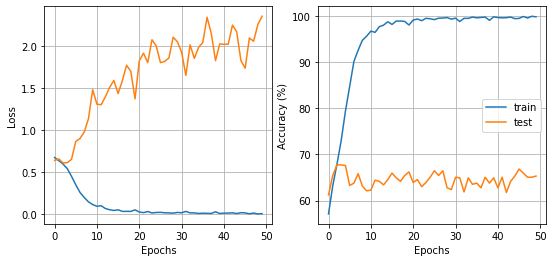

In [ ]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.grid()

plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.plot(train_accs, label = "train")
plt.plot(test_accs, label = "test")
plt.legend()
plt.grid()

In [ ]:
pre_l = []
for i in pred_labels:
  pre_l.extend(i.to("cpu").numpy().tolist())
pre_l = np.array(pre_l)

print("Precision (P):", metrics.precision_score(true_labels, pre_l))
print("Recall (R):", metrics.recall_score(true_labels, pre_l))
print("F1 score (F):", metrics.f1_score(true_labels, pre_l))
print()
print("Classification Report")
print(metrics.classification_report(true_labels, pre_l))

Precision (P): 0.5522788203753352
Recall (R): 0.662379421221865
F1 score (F): 0.6023391812865497

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       473
           1       0.55      0.66      0.60       311

    accuracy                           0.65       784
   macro avg       0.65      0.65      0.65       784
weighted avg       0.67      0.65      0.66       784

